In [1]:
import torch, torchvision
from torch.utils.cpp_extension import CUDA_HOME; 

#check versions and CUDA
print(torch.__version__)
!gcc --version
print(torch.version.cuda)
print(torch.cuda.is_available(), CUDA_HOME)

1.8.1
gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-44)
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

10.1
True /usr/local/cuda


In [2]:
#!python -m detectron2.utils.collect_env

In [3]:
import sys
sys.path

['/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python37.zip',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7/lib-dynload',
 '',
 '/camp/home/ritot/.local/lib/python3.7/site-packages',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7/site-packages',
 '/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/lib/python3.7/site-packages/IPython/extensions',
 '/nemo/project/home/ritot/.ipython']

In [4]:
sys.executable

'/camp/home/ritot/home/users/ritot/nucleus_t18/nucleys_t18/bin/python3.7'

In [5]:
# there is a detectron wrong version somwhr.. make sure path is only the env one

# sys.path.remove('/camp/lab/briscoej/working/tiago/nucleus_test1/Nucleus/notebooks')
sys.path.remove('/camp/home/ritot/.local/lib/python3.7/site-packages')
#sys.path.remove('/camp/home/ritot/.ipython')
sys.path.remove('')

In [24]:
%load_ext autoreload
%autoreload 2

# import common libraries
import numpy as np
import cv2
import os
import random
import matplotlib.pylab as plt
from PIL import Image
import tqdm 
import timeit
from math import floor

# import some detectron2 utilities
import detectron2
print(detectron2.__version__)
import sys
sys.path.append('../')

from Nucleus import ImageInput
from Nucleus import ImageTile
from Nucleus import Stitcher
from detectron2_predict import detectron_predict
from detectron2_predict import detectron_init
from utils import PNG_to_JSON
from Nucleus import coco_nucleus
from Nucleus import get_feature_table_2D

from skimage import io
import tifffile

Nucleus
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4


# Step 1: get segmentation for all images

1. Pick a single z-plane (if fine z-stack was aquired probably 2-3 planes can be collapsed in a max projection but bear in mind the algorithm was trained on images that do not have overlapping nuclei).

2. Size should multiple of 128 - now there is a check that ensures this by generating a cropped version. 


In [7]:
os.getcwd()

'/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks'

In [8]:


ROOT_PATH = '/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks/Lizzie/'
os.listdir(ROOT_PATH)
#os.mkdir(ROOT_PATH+"/img")
#os.mkdir(ROOT_PATH+"/masks")

['img', 'features_table.csv', 'masks']

In [9]:
import glob
import shutil
dest_dir = ROOT_PATH+"/img"
for file in glob.glob(ROOT_PATH+'/*.tif'):
    print(file)
    shutil.move(file, dest_dir)

In [12]:

#there should be a img and masks folders inside ROOT_PATH.

NUCLEAR_Ch = 0 # zero-indexed => 0 corresponds to channel 1

#lists all images to be segmented
images_to_segment = os.listdir(ROOT_PATH+"img/")
print(images_to_segment)

['cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif', 'Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif', 'cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb3_Merged.tif', 'Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb2_Merged.tif', 'cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb2_Merged.tif', 'Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb3_Merged.tif']


In [11]:
input_img=images_to_segment[0]
im = io.imread(ROOT_PATH+"img/"+input_img)
print(input_img)
print(im.shape)

Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif
(1891, 1936, 4)


(-0.5, 1935.5, 1890.5, -0.5)

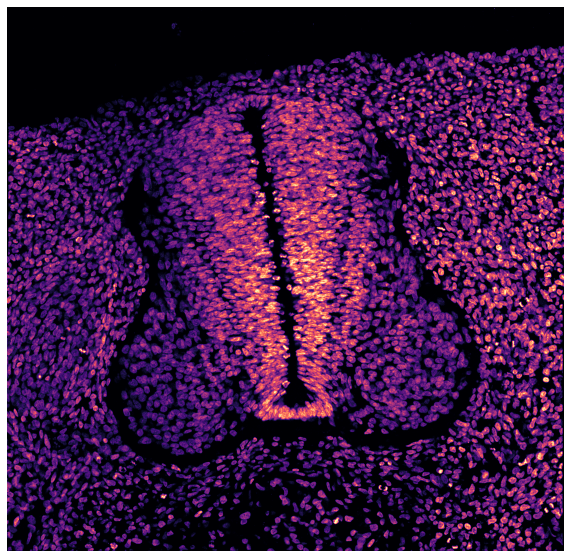

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(im[:,:,0], cmap='magma'); plt.axis('off')

In [15]:
for i in range(0,len(images_to_segment)):
    print(images_to_segment[i])

Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif
Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb2_Merged.tif
Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb3_Merged.tif


In [43]:
for i in range(0,len(images_to_segment)):
    input_img = images_to_segment[i]
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    print(im.shape)
    im = im[0:floor(im.shape[0]/128)*128,
            0:floor(im.shape[1]/128)*128, :]
    print(im.shape)
    im =np.moveaxis(im, -1, 0)
    #im = np.expand_dims(im, axis=0)
    print(im.shape)      #z, channel, x, y 
    tifffile.imwrite(ROOT_PATH+"img/"+'crop'+input_img,
            im,
            imagej=True,
            photometric='minisblack',
            planarconfig='contig',
            #compression='zlib',
            metadata={'axes': 'CYX'})
    

Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif
(1891, 1936, 4)
(1792, 1920, 4)
(4, 1792, 1920)
Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb2_Merged.tif
(1914, 1935, 4)
(1792, 1920, 4)
(4, 1792, 1920)
Nr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb3_Merged.tif
(1937, 1938, 4)
(1920, 1920, 4)
(4, 1920, 1920)


In [13]:
images_to_segment = os.listdir(ROOT_PATH+"img/")

images_to_segment = [x for x in images_to_segment if ("crop" in x)]

images_to_segment

['cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif',
 'cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb3_Merged.tif',
 'cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb2_Merged.tif']

In [46]:

for k in range(0,len(images_to_segment)):    
   
    input_img=images_to_segment[k]
    print("Segmenting image:")
    print(input_img)
    im = io.imread(ROOT_PATH+"img/"+input_img)
    im = np.moveaxis(im, -1, 0)
    print(im.shape)
    

    sz=im[NUCLEAR_Ch,:,:] # im[z,:,:,0] #why this difference? tiff format?
    print(sz.shape)

    # interpolate image to higher size 
#     sz= cv2.resize(sz, (0,0), fx=2, fy=2, interpolation=cv2.INTER_LANCZOS4) # just for predictor
#     im = Image.fromarray(sz) # do not save
#     input_img = input_img+"_mod.tif"
#     im.save(ROOT_PATH+"/img/"+input_img)
#     tifffile.imsave(ROOT_PATH+"img/"+input_img, sz)
#     print(sz.shape)
#     print(input_img)

    
    
    one = ImageInput(img_str=sz, step=128) 
    #one.show_me()



    # split image in tiles for 'stitch_v1' 
    m_tiles, v_tiles, h_tiles = one.make_tiles('stitch_v1')

    #just shows an example
    #m_tiles[4].show_me()

    #print(np.shape(m_tiles[7].img))



    # Predicting for : 'stitch_v1'
    print("Predicting...")

    pred= detectron_init(model='SC_sections') # 'invitro'  or 'SC_sections'

    tic=timeit.default_timer()
    print("Main_tiles")
    m_out = [detectron_predict(_im,pred) for _im in m_tiles] 
    print("V_tiles")
    v_out = [detectron_predict(_im,pred) for _im in v_tiles]
    print("H_tiles")
    h_out = [detectron_predict(_im,pred) for _im in h_tiles]
    toc=timeit.default_timer()
    #print('The time was {:.2f} sec'.format(toc - tic))
    
    
    # Stitching
    print("Stitching...")
    tic=timeit.default_timer()
    test = Stitcher(one)
    seg_mask, nuclei_tally = test.stitch_v1([m_tiles,v_tiles,h_tiles] , [m_out, v_out, h_out], margin=6)
    toc=timeit.default_timer()
    #print('The time was {:.2f} sec'.format(toc - tic))
    #plt.figure(figsize=(8,8))
    #plt.imshow(seg_mask)
    print(f'This image has {nuclei_tally} segmented nuclei.')
    
    
    
    # save mask 
    print("Saving...")
    #im_seg = cv2.resize(seg_mask, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST) #scale mask to fit original input
    #im_seg = Image.fromarray(im_seg)
    im_seg = Image.fromarray(seg_mask)
    #print(im_seg.shape)
    im_seg.save(ROOT_PATH+"masks/"+input_img)
    print("Segm mask saved.")
    
    
    
    # save JSON
    tic=timeit.default_timer()
    PNG_to_JSON.main(ROOT_DIR=ROOT_PATH,
                            image_files=[input_img], 
                            output= ROOT_PATH+"masks/"+ input_img +'_.json') 
    toc=timeit.default_timer()
    print('json saved. The time for saving json was {:.2f} sec'.format(toc - tic))
    
    
    
    
    # save overlay segmentation and image
    segmFile =ROOT_PATH+"masks/"+input_img+'_.json'
    imgDir   = ROOT_PATH+"img/"
    output_imageFile = ROOT_PATH+"masks/z"+input_img+'_coco_out.png'
    pick_image_number=0

    coco=coco_nucleus(segmFile)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]
    print('COCO categories: \n{}\n'.format(' '.join(nms)))
    catIds = coco.getCatIds(catNms=['nucleus']);
    imgIds = coco.getImgIds(catIds=catIds);
    img = coco.loadImgs(imgIds[pick_image_number])[0]

    fig = plt.figure(figsize=(18,18))

    input_img+"_mod.tif"
    I = io.imread(imgDir+img['file_name'])
    I = np.moveaxis(I, -1, 0)
    I = np.asarray(I[NUCLEAR_Ch,:,:]) #[z,:,:,0]


    plt.imshow(I, cmap='magma'); plt.axis('off')
    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds)
    anns = coco.loadAnns(annIds)
    coco.showAnns_Nucleus(anns)
    plt.savefig(output_imageFile,dpi=150,bbox_inches='tight',pad_inches=0)
    plt.close()

    print("saved overlay. All done.")
    print("\n\n\n\n\n")


Segmenting image:
cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif
(4, 1792, 1920)
(1792, 1920)
Using step of 128px.
Splitting image in main tiles...
Splitting image in vertical border tiles...
Splitting image in horizontal border tiles...
Predicting...
Main_tiles
V_tiles
H_tiles
Stitching...
This image has 5209 segmented nuclei.
Saving...
Segm mask saved.
/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks/Lizzie/
None
/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks/Lizzie/masks/cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif_.json
Supply z-slice of original image. zero if none.
cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif
(1792, 1920, 4)
5172
The time for annotation info was 39.86 sec
Done saving JSON!
json saved. The time for saving json was 40.17 sec
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
COCO categories: 
nucleus

saved overlay. All done.


# Get Features Table

In [15]:
import pandas as pd
output_table=ROOT_PATH +"features_table.csv"
output_table

'/nemo/lab/briscoej/home/users/ritot/nucleus_t18/Nucleus/notebooks/Lizzie/features_table.csv'

In [25]:
df=[]

for input_img in images_to_segment:
    img = io.imread(ROOT_PATH+"img/"+input_img)
    print(img.shape)
    
    masks = io.imread(ROOT_PATH+"masks/"+input_img )
    masks = np.array(masks)
    print(masks.shape) # X, Y, Ch
    
    img_df= get_feature_table_2D(input_img, img, masks)
    
    df= df+img_df
    
    
    
Data = pd.DataFrame(df, columns=('Image', 'Instance', 'nuclear_avgs',
                      'area','Elipse_centre','Elipse_major_minor','Elipse_angle',
                             'Centroid',
                            'hood_avgs',
                            'cyto_avgs'))

Data.to_csv(output_table, index=False)

Data

(1792, 1920, 4)
(1792, 1920)
strange mask with >1 contours
10
strange mask with >1 contours
33
strange mask with >1 contours
129
strange mask with >1 contours
181
strange mask with >1 contours
182
strange mask with >1 contours
273
strange mask with >1 contours
274
strange mask with >1 contours
452
strange mask with >1 contours
454
strange mask with >1 contours
455
strange mask with >1 contours
493
strange mask with >1 contours
566
strange mask with >1 contours
593
strange mask with >1 contours
613
strange mask with >1 contours
651
strange mask with >1 contours
677
strange mask with >1 contours
698
strange mask with >1 contours
747
strange mask with >1 contours
820
strange mask with >1 contours
849
strange mask with >1 contours
864
strange mask with >1 contours
892
strange mask with >1 contours
970
strange mask with >1 contours
1030
strange mask with >1 contours
1040
strange mask with >1 contours
1076
strange mask with >1 contours
1262
strange mask with >1 contours
1268
strange mask wit

strange mask with >1 contours
4385
strange mask with >1 contours
4435
strange mask with >1 contours
4441
strange mask with >1 contours
4444
strange mask with >1 contours
4457
strange mask with >1 contours
4458
strange mask with >1 contours
4468
strange mask with >1 contours
4469
strange mask with >1 contours
4482
strange mask with >1 contours
4658
strange mask with >1 contours
4690
strange mask with >1 contours
4698
strange mask with >1 contours
4779
strange mask with >1 contours
4784
strange mask with >1 contours
4786
strange mask with >1 contours
4788
strange mask with >1 contours
4869
strange mask with >1 contours
4871
strange mask with >1 contours
5022
strange mask with >1 contours
5086
strange mask with >1 contours
5096
strange mask with >1 contours
5133
strange mask with >1 contours
5165
strange mask with >1 contours
5239
strange mask with >1 contours
5344
strange mask with >1 contours
5357
strange mask with >1 contours
5358
strange mask with >1 contours
5398
strange mask with >1

,Image,Instance,nuclear_avgs,area,Elipse_centre,Elipse_major_minor,Elipse_angle,Centroid,hood_avgs,cyto_avgs
0,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,1,"[14.75, 10.0, 10.5, 5.25]",207,"(577.8876953125, 65.36901092529297)","(12.820263862609863, 18.921783447265625)",0.992363,"(577, 65)","[14.75, 10.0, 10.5, 5.25]","[14.75, 10.0, 10.5, 5.25]"
1,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,2,"[22.75, 43.25, 34.0, 44.5]",388,"(840.935791015625, 235.70196533203125)","(18.732437133789062, 25.167652130126953)",131.090683,"(840, 235)","[22.75, 43.25, 34.0, 44.5]","[22.75, 43.25, 34.0, 44.5]"
2,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,4,"[6.5, 12.5, 6.75, 16.25]",377,"(874.1459350585938, 226.23733520507812)","(20.95937728881836, 23.65304946899414)",45.244305,"(874, 226)","[6.5, 12.5, 6.75, 16.25]","[6.5, 12.5, 6.75, 16.25]"
3,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,5,"[17.25, 20.75, 24.25, 23.5]",70,"(843.0879516601562, 221.6553955078125)","(4.6540117263793945, 17.15235137939453)",89.906670,"(843, 221)","[17.25, 20.75, 24.25, 23.5]","[17.25, 20.75, 24.25, 23.5]"
4,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,6,"[32.25, 30.75, 30.5, 33.75]",233,"(994.3666381835938, 223.5270538330078)","(13.035102844238281, 21.116376876831055)",68.976372,"(994, 223)","[32.25, 30.75, 30.5, 33.75]","[32.25, 30.75, 30.5, 33.75]"
...,...,...,...,...,...,...,...,...,...,...
15597,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,4973,"[44.0, 44.5, 40.75, 52.75]",415,"(1912.0662841796875, 1667.2454833984375)","(22.56244659423828, 31.26664161682129)",101.599312,"(1909, 1667)","[44.0, 44.5, 40.75, 52.75]","[44.0, 44.5, 40.75, 52.75]"
15598,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,4974,"[73.75, 69.25, 77.5, 89.75]",252,"(1893.4178466796875, 1671.7269287109375)","(15.82904052734375, 20.427762985229492)",165.668411,"(1893, 1671)","[73.75, 69.25, 77.5, 89.75]","[73.75, 69.25, 77.5, 89.75]"
15599,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,4975,"[66.75, 57.25, 73.75, 71.25]",203,"(1883.45947265625, 1661.0609130859375)","(10.802596092224121, 21.868507385253906)",84.278374,"(1883, 1661)","[66.75, 57.25, 73.75, 71.25]","[66.75, 57.25, 73.75, 71.25]"
15600,cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.li...,4976,"[34.5, 22.75, 25.25, 29.0]",236,"(1783.1912841796875, 1667.320556640625)","(11.41037654876709, 24.428491592407227)",54.135689,"(1782, 1667)","[34.5, 22.75, 25.25, 29.0]","[34.5, 22.75, 25.25, 29.0]"


In [30]:
np.unique(Data.Image)

array(['cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - Ctrl-sect3-emb4.tif',
       'cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb2_Merged.tif',
       'cropNr6a1OE_Sox2-488_RFP-568_DAPI_Zfhx3-647.lif - NR6a1-sect1_nr6a1-emb3_Merged.tif'],
      dtype=object)

In [ ]:
#OLD

In [ ]:
# check cytoplasm/ hood mask


print(input_img)

img = io.imread(ROOT_PATH+"img/"+input_img)
img = np.moveaxis(img, -1, 0)
sz=img
    
print(sz.shape)


segmFile =ROOT_PATH+"/masks/"+input_img+'_.json'
coco=coco_nucleus(segmFile)
annids = coco.getAnnIds()
anns = coco.loadAnns(annids)
print("Number of nuclei:")
print(len(anns))

inst= 105

print(anns[inst]['segmentation'])

mask = coco.annToMask(anns[inst])
#plt.imshow(mask)
locs = np.where(mask == 1)
#rint(len(locs[0]))
if len(locs[0])>20: #basic filter for very small detections <20 pixels

    #channel averages
    ch1_avg = round(np.mean(img[0][locs]),3) 
    ch2_avg = round(np.mean(img[1][locs]),3)
    ch3_avg = round(np.mean(img[2][locs]),3)
    ch4_avg = round(np.mean(img[3][locs]),3) # can add if to check if there are these many channels

    #shape
    aspect_ratio = round(anns[inst]['bbox'][2]/anns[inst]['bbox'][3],3)


    # centroid coordinates in original image.
    contours,hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours)==1:
        cnt = contours[0]
    else:
        print("strange mask with >1 contours")
        print(anns[inst]['id'])
        xi=0
        xi_len=len(contours[xi])

        for i in range(len(contours)): 
            if len(contours[i])>xi_len:
                xi=i
                cnt = contours[i]
    M = cv2.moments(cnt)
    #print(M)
    cx = int(M['m10']/M['m00'])    
    cy = int(M['m01']/M['m00'])
    area = cv2.contourArea(cnt)
    if len(cnt)>5: # ensures there are enough points to call elipse
        (x,y),(MA,ma), angle = cv2.fitEllipse(cnt)
    else:
        (x,y),(MA,ma), angle = (np.nan,np.nan),(np.nan,np.nan), np.nan


    #get info on hood
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask_hood = cv2.dilate(mask, kernel, iterations=10)    
    locs = np.where(mask_hood == 1)
    #channel averages
    ch1_avg_hood = round(np.mean(img[0][locs]),3) 
    ch2_avg_hood = round(np.mean(img[1][locs]),3)
    ch3_avg_hood = round(np.mean(img[2][locs]),3)
    ch4_avg_hood = round(np.mean(img[3][locs]),3) # can add if to check if there are these many channels


    #get info on immediate hood ~ cytoplasm ideally?
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    mask_cyto = cv2.dilate(mask, kernel, iterations=6)
    mask_cyto = mask_cyto - mask   
    locs = np.where(mask_cyto == 1)
    #channel averages
    ch1_avg_cyto = round(np.mean(img[0][locs]),3) 
    ch2_avg_cyto = round(np.mean(img[1][locs]),3)
    ch3_avg_cyto = round(np.mean(img[2][locs]),3)
    ch4_avg_cyto = round(np.mean(img[3][locs]),3) # can add if to check if there are these many channels

    
    
    locs = np.where(mask_hood == 1)


    #locs = np.where(mask_cyto == 1)

    plt.figure(figsize=(15,15))
    plt.imshow(img[0,:,:], cmap='Greys_r')
    plt.scatter(locs[1],locs[0],alpha=0.05,c='red',s=1)


In [ ]:
output_table = '/camp/lab/briscoej/working/tiago/nucleus_t18/Nucleus/notebooks/Joaquina/IP-jsbh208_1fA_003-1.tiffeatures_table.csv'

In [ ]:
import ast
df=pd.read_csv(output_table, converters={"Centroid": ast.literal_eval})
df

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(231)
plt.hist(df['Ch1_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch1 - DAPI')
plt.subplot(232)
plt.hist(df['Ch2_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch2 - 647')
plt.subplot(233)
plt.hist(df['Ch3_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch3 - 488')

plt.subplot(234)
plt.hist(df['Ch4_avg_signal'], 100, density=True, facecolor='black', alpha=0.95)
plt.title('Ch4 - 594')
#plt.subplot(235)
#plt.hist(df['ch5_cell_avg'], 100, density=True, facecolor='black', alpha=0.95)
#plt.title('Ch5 - 514')
#plt.subplot(236)